# PROYECTO 2. MACHINE LEAERNING APLICADO A MARKETING BANCARIO

# 0. PASOS PREVIOS

## 0.1  Librerías

In [2]:
# Genéricos
import numpy as np
import pandas as pd
from datetime import date
import json
from numpy import unique
from numpy import where
from matplotlib import pyplot
from ydata_profiling import ProfileReport
from collections import Counter


# Visualización
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import Image
import cufflinks as cf
from IPython.display import display,HTML
import folium
import cufflinks as cf
from IPython.display import display,HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt



# Algoritmos Machine Learning:
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB


# Feature Selection:
from sklearn.feature_selection import VarianceThreshold

# Métricas clasificadores
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Balanceado de clases
from imblearn.over_sampling import SMOTE 


# Optimización de Parámetros
from sklearn.model_selection import GridSearchCV




# Otras configuraciones
pd.set_option("display.max.columns", None) ## ver todas columnas df pandas
%matplotlib inline


SystemError: initialization of _internal failed without raising an exception

## 0.2 Funciones

In [2]:
def EDA_inicial(DF):
    a = DF.shape
    b = DF.describe()
    c = DF.info()
    print("Info:\n",c,"\n")
    print("Shape:\n",a, "\n")
    print("Estadisticos:\n",b,"\n")

In [3]:
def graficos_eda_categoricos(cat):
    
    #Calculamos el número de filas que necesitamos
    from math import ceil
    filas = ceil(cat.shape[1] / 2)

    #Definimos el gráfico
    f, ax = plt.subplots(nrows = filas, ncols = 2, figsize = (16, filas * 6))

    #Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
    ax = ax.flat 

    #Creamos el bucle que va añadiendo gráficos
    for cada, variable in enumerate(cat):
        cat[variable].value_counts().plot.barh(ax = ax[cada])
        ax[cada].set_title(variable, fontsize = 12, fontweight = "bold")
        ax[cada].tick_params(labelsize = 12)

In [4]:
def estadisticos_cont(num):
    #Calculamos describe
    estadisticos = num.describe().T
    #Añadimos la mediana
    estadisticos['median'] = num.median()
    #Reordenamos para que la mediana esté al lado de la media
    estadisticos = estadisticos.iloc[:,[0,1,8,2,3,4,5,6,7]]
    #Lo devolvemos
    return(estadisticos)

In [5]:
def atributos_fechas(x):
    x['año'] = x.index.year
    x['mes'] = x.index.month_name()
    x['dia_mes'] = x.index.day
    x['dia_semana'] = x.index.day_name()
    x['hora'] = x.index.hour
    return(x)

In [6]:
def nulos(df):
    
    x = df.isnull().sum()/len(df)*100
    x = pd.DataFrame(x)
    return x

In [7]:
def outliers(df, columna):
    outliers = 0
    #Saber los outliers
    # Calcular el rango intercuartil (IQR)
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1

    # Calcular los límites inferior y superior para identificar outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Identificar los outliers
    outliers = df[(df[columna]< limite_inferior) | (df[columna] > limite_superior)]

    # Imprimir los outliers
    print(f"Outliers_{columna}: {outliers.shape[0]}")
    print(f"Los outliers de esta columna represetan: {round(outliers.shape[0]/ len(df)*100, 2)} %")
    
    return outliers

In [8]:
def grafico(df,columna):
    plt.figure(figsize= (7,4))
    plt.title(columna.title())
    sns.histplot(df[columna])
    plt.show()

In [9]:
def concat_dummies(df, columna):
    df= pd.concat([df, pd.get_dummies(data = df[columna], drop_first = True,
                                          prefix = columna.title())], axis = 1)
    
    df.drop(columna, axis = 1, inplace = True)
    return df 

# 1. INTRODUCCIÓN

## 1.1. Descripción del caso

El sector bancario ha sido pionero en aplicar Ciencia de Datos para la optimización de sus procesos. En España, y más tarde en Portugal, los grandes bancos llevan utilizando modelos de estadística predictiva y minería de datos desde finales de los años 80, siendo uno de los sectores que más ha contribuido a desarrollar el conjunto de áreas de conocimiento que a día de hoy se conoce como Ciencia de Datos.

La crisis económica de 2008 implicó para las entidades bancarias la necesidad de buscar modelos de negocio más eficientes y optimizar los servicios, tanto en términos cualitativos como cuantitativos, teniendo especial importancia en los procesos de negocio en los que la captación y fuga de clientes, tienen un gran impacto.

El objeto de este proyecto es identificar y optimizar un modelo de Machine Learning que permita predecir la captación de Clientes de productos bancarios. Aunque se trate de un caso específico, con un desarrollo muy particularizado para el sector bancario, buena parte de las herramientas de exploración, tratamiento, y explotación de datos utilizadas para este desarrollo, son aplicables a otros sectores y tipos de proyecto.



## 1.2. Descripción del DATASET

Los datos están relacionados con campañas de marketing directo de una institución bancaria portuguesa. Las campañas de marketing se basaron en llamadas telefónicas. A menudo, se requería más de un contacto con el mismo cliente, para poder acceder a si el producto (depósito bancario a plazo) estaría o no suscrito.
   
#### Conjuntos de datos: 
   1) bank-full.csv con todos los ejemplos, ordenados por fecha (de mayo de 2008 a noviembre de 2010).
   2) bank.csv con el 10% de los ejemplos (4521), seleccionados aleatoriamente de bank-full.csv. 
   
El conjunto de datos más pequeño se proporciona para probar algoritmos de aprendizaje automático.
El objetivo de la clasificación es predecir si el cliente suscribirá un depósito a plazo (variable y). 

    1. Número de instancias: 45211 para bank-full.csv (4521 para bank.csv) 
    4. Número de atributos: 16 + atributo de salida. 
    5. Información de atributos: Para obtener más información.
     
   #### Variables de entrada:
   
    #  datos del cliente del banco: 
      1 - edad (numérico) 
      2 - trabajo: tipo de trabajo(categórico:"administrador","desconocido","desempleado", "gerencia", "criada",             "empresario"," estudiante", "cuello azul", "trabajador por cuenta propia", "jubilado", "técnico", "servicios").
      3 - civil: estado civil (categórico: "casado", "divorciado", "soltero"; nota: "divorciado" significa divorciado o viudo)
      4 - educación (categórica: "desconocida", "secundaria", "primaria", "terciaria") 
      5 - mora: ¿tiene crédito en mora? (binario: "sí","no")
      6 - saldo: saldo medio anual, en euros (numérico)
      7 - vivienda: ¿tiene préstamo vivienda? (binario: "sí","no")
      8 - préstamo: ¿tiene préstamo personal? (binario: "si","no") 
      
   #### Relacionado con el último contacto de la campaña actual:
      9 - contacto: tipo de comunicación del contacto (categórico: "desconocido","teléfono","celular")
     10 - día: último contacto día del mes (numérico)
     11 - mes: último contacto mes del año (categórico: "ene", "feb", "mar", ..., "nov", "dec")
     12 - duración: duración del último contacto , en segundos (numérico)
     
  
    #### Otros atributos:
     13 - campaña: número de contactos realizados durante esta campaña y para este cliente (numérico, incluye               último contacto)
     14 - pdays: número de días que pasaron después de que el cliente fue contactado por última vez desde un                 campaña anterior (numérico, -1 significa que el cliente no fue contactado previamente) 
     15 - anterior: número de contactos realizados antes de esta campaña y para este cliente (numérico)
     16 - resultado: resultado de la campaña de marketing anterior (categórico: "desconocido","                             otro","fracaso","éxito") 
     
            
  #### Variable de salida (objetivo deseado):
   
     17 - y - ¿el cliente ha suscrito un depósito a plazo? (binario: "sí","no")

## 1.3. Objetivos

El objetivo del proyecto es programar un modelo de Machine Learning que permita predecir la captación de Clientes. Para ello, se requiere del desarrollo de los siguientes subojetivos.

### 1.3.1. Conceptuales y Estratégicos
a) Definición del problema. 
b) Identificación del algoritmo o algoritmos aplicables.
c) Capacidad para seleccionar la informaición de mayor relevancia para la elección del agorirtmo.
d) Capacidad para comunicar resultados y dificultades del proyecto.

### 1.3.2. Técnicos
a) Realizar la carga de datos (extracción o carga). 
b) Ejecución de EDA (Exploratory Data Analysis).
c) Selección del modelo y justificación técnica.
d) Validación del modelo.
e) Industrialización del modelo.
f) Comunicación de resultados.

## 1.4. Autores del estudio

#### Adriana Pérez Olivares

##### LinkedIN: https://www.linkedin.com/in/adrianaperezolivares/

#### Iván García Reyes

##### LinkedIN: https://www.linkedin.com/in/ivan-garcia-reyes/

#### Carlos Garrido Muñoz

##### LinkedIN:https://www.linkedin.com/in/carlosgarridomunoz/

#### Lucas Fernández Martínez

##### LinkedIN: https://www.linkedin.com/in/lucas

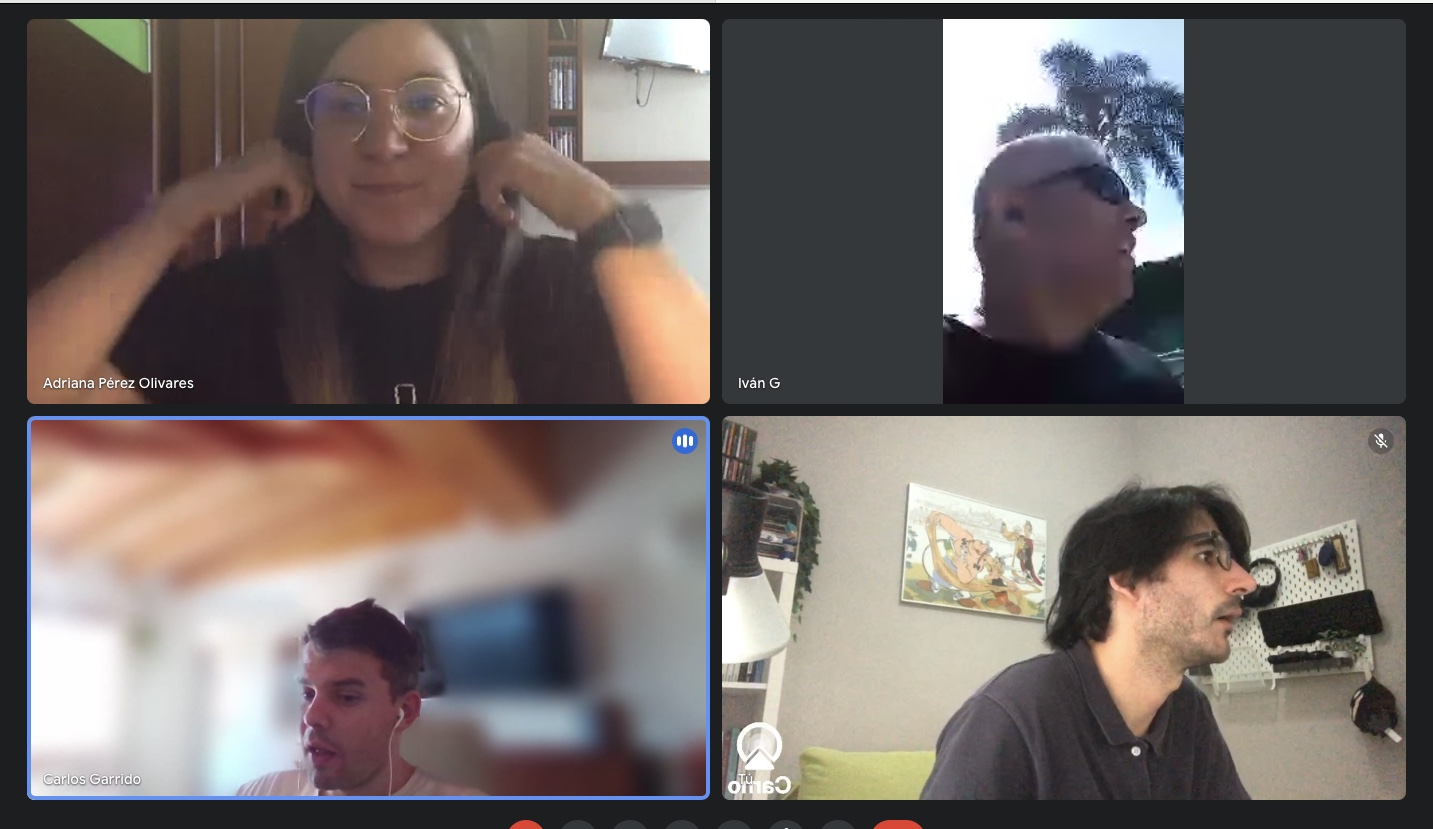

# 2. CARGA DE LOS DATOS

Carga del csv directamente desde el ordenador, obtenido de un repositorio Kaggle.

In [4]:
df = pd.read_csv('bank-full.csv', sep = ';',  na_values='#N/D')

# 3. EXPLORATORY DATA ANALYSIS (EDA)

In [5]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [12]:
EDA_inicial(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
Info:
 None 

Shape:
 (45211, 17) 

Estadisticos:
                 age        balance           day

La columna "day" requiere de ser transformada a objeto tipo datetime.

In [13]:
df["y"] = df["y"].apply(lambda x : 0 if x == "no" else 1)

In [14]:
df["y"].value_counts()

0    39922
1     5289
Name: y, dtype: int64

Cambiamos el tipo de dato entero int64 a int32 buscando feducir el consumo de memoria y mejorar la eficiencia en el almacenamiento y procesamiento de datos.

In [15]:
df = df.astype({"age": "int32", "balance": "int32", "day": "int32",
                          "duration": "int32", "campaign": "int32", "pdays": "int32",
                          "pdays": "int32", "previous": "int32", "y": "int32"})

<AxesSubplot:>

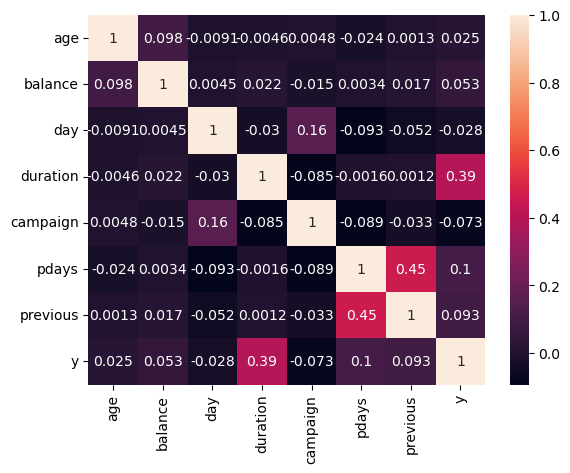

In [16]:
sns.heatmap(df.corr(), annot = True)

## 3.1 Análisis de nulos

In [17]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

No se identifican nulos.

## 3.2 Análisis de duplicados

In [18]:
unique(df.duplicated())

array([False])

## 3.3 Análisis de Variables

Se procederá a una primera visualización de la información del DataFrame con los siguientes objetivos:
1. Identificar las principales características del DF.
2. Identificar y tratar Outliers.
3. Identificar y eliminar variables sin interés para el estudio.
4. Normalización de datos datos (no se eralizará).
5. Dimnensionalidad (se balanceará el Data Set en el segundo Notebook)

### 3.2.1 Variables categóticas

Realizamos una primea exploración visual.

Eliminamos columnas que consideramos no son relevantes.

In [19]:
df.drop( ["month", "poutcome"], axis=1, inplace = True)

#### A) Marital

Unimos "Soltero" con "Divorciado" dada su similitud en la oferta de servicios y estilo de vida.

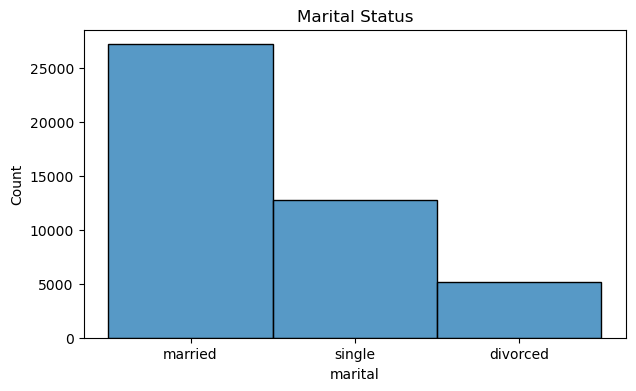

In [20]:
plt.figure(figsize= (7,4))
plt.title("Marital Status")
sns.histplot(df["marital"])
plt.show()

In [21]:
df["marital"] = df["marital"].replace({"divorced" : "single"})

In [22]:
df["marital"].value_counts(normalize= True)*100

married    60.193316
single     39.806684
Name: marital, dtype: float64

#### B) Contact

Unimos "Unknown" con "telephone"

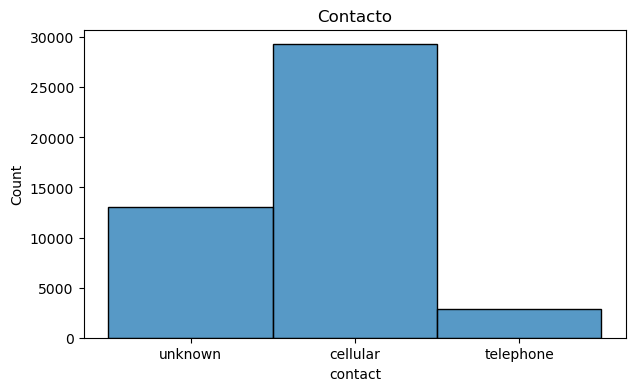

In [23]:
plt.figure(figsize= (7,4))
plt.title("Contacto")
sns.histplot(df["contact"])
plt.show()

In [24]:
df["contact"] = df["contact"].replace({"unknown" : "telephone"})

Valoramos la union de unknown y telephone

In [25]:
df["contact"].value_counts(normalize= True)*100

cellular     64.774059
telephone    35.225941
Name: contact, dtype: float64

#### C) Housing, loan, contact

Vamos a explorarlas y hacer get dunmies con ellas y otras variables ya que tienen pocas categorías.

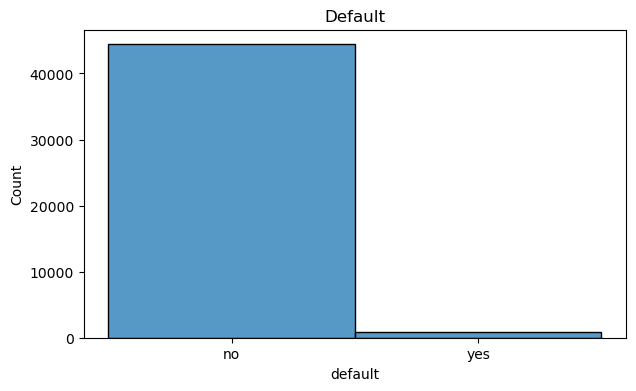

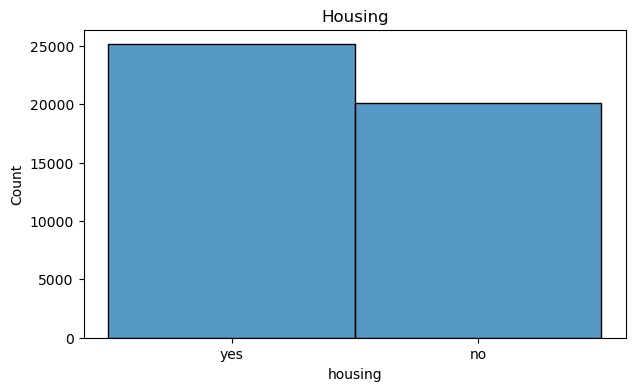

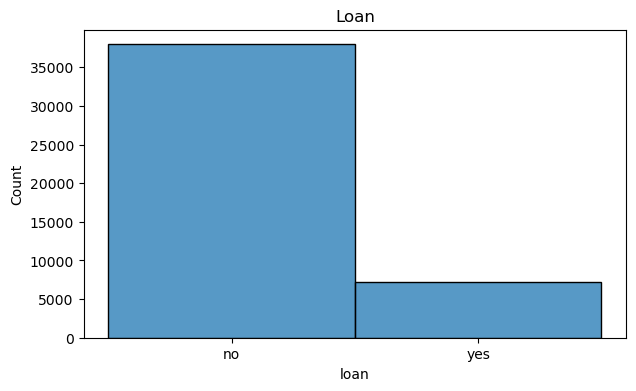

In [26]:
for i in ["default", "housing", "loan"]:
    grafico(df, i)

In [27]:
columnas=["marital", "default", "housing", "loan", "contact"]

for i in columnas:
    df= concat_dummies(df, i)

df.head()

,age,job,education,balance,day,duration,campaign,pdays,previous,y,Marital_single,Default_yes,Housing_yes,Loan_yes,Contact_telephone
0,58,management,tertiary,2143,5,261,1,-1,0,0,0,0,1,0,1
1,44,technician,secondary,29,5,151,1,-1,0,0,1,0,1,0,1
2,33,entrepreneur,secondary,2,5,76,1,-1,0,0,0,0,1,1,1
3,47,blue-collar,unknown,1506,5,92,1,-1,0,0,0,0,1,0,1
4,33,unknown,unknown,1,5,198,1,-1,0,0,1,0,0,0,1


#### D) Job

Aquí se ve desbalance entre las categorias, se podria agrupar (unknown + student+ housemaid+
unemploymed + retired) y otra categoria(entrepreneur + selfemployed + services)

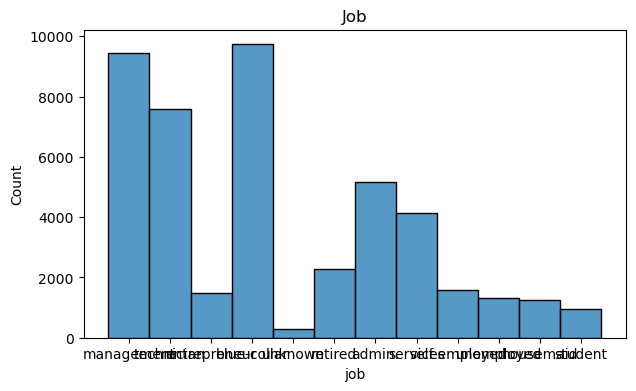

In [28]:
plt.figure(figsize= (7,4))
plt.title("Job")
sns.histplot(df["job"])
plt.show()

In [29]:
df["job"].value_counts(normalize= True)*100

blue-collar      21.525735
management       20.919688
technician       16.803433
admin.           11.437482
services          9.188029
retired           5.007631
self-employed     3.492513
entrepreneur      3.289023
unemployed        2.882042
housemaid         2.742695
student           2.074716
unknown           0.637013
Name: job, dtype: float64

In [30]:
job_labelEncoding = LabelEncoder()
job_labelEncoding.fit(df["job"].values)
job = job_labelEncoding.transform(df["job"].values)
df["job"] = job

#### E) Education

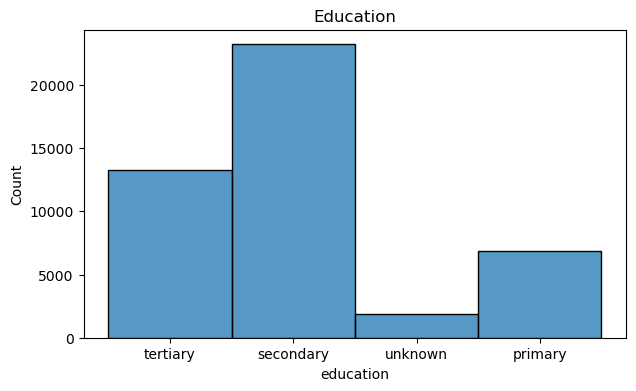

In [31]:
plt.figure(figsize= (7,4))
plt.title("Education")
sns.histplot(df["education"])
plt.show()

In [32]:
df["education"].value_counts(dropna = False)

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

De esta manera quitamos 15.000 registros incompletos.

A continuacion exploramos los perfiles difernciales de los eventos exitosos y los que no lo son:

### 3.2.3 Variables numéricas (Tratamiento Outliers) 

A continuación se exploran las variables numéricas, y se tratan los valores anormales. Para ello aplicamos la función definida en el punto 0.

#### A) Duration

In [33]:
df_outliers_duration = outliers(df, "duration")


Outliers_duration: 3235
Los outliers de esta columna represetan: 7.16 %


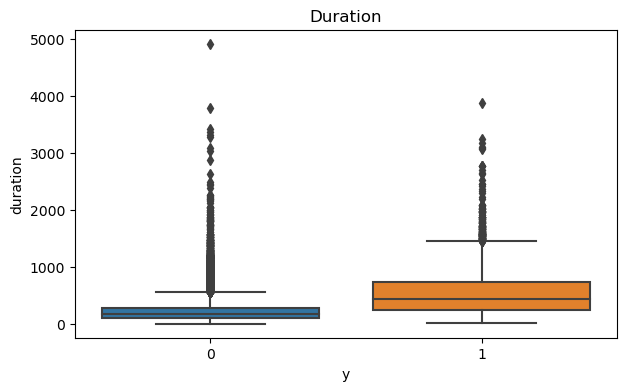

In [34]:
plt.figure(figsize= (7,4))
plt.title("Duration")
sns.boxplot( x= df["y"], y= df["duration"])
plt.show()


Son los Outliers de duration, pero con la y=0, de esta manera no disminuimos y=1

In [35]:
df_outliers_duration.shape[0]

3235

Quedaria este dataframe al eliminarlo:

In [36]:
df = df.drop(df_outliers_duration.index)

#### B) Age

A partir de los 70 años se considera que hay outliers

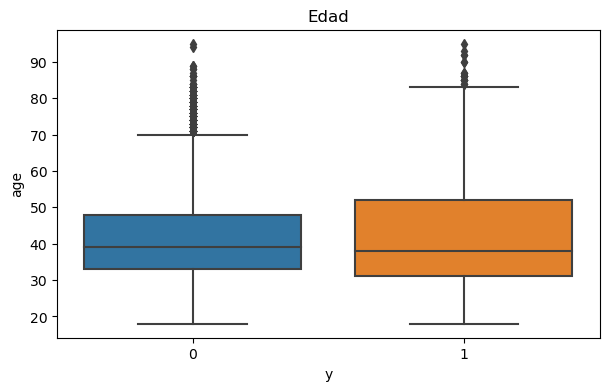

In [37]:
plt.figure(figsize= (7,4))
plt.title("Edad")
sns.boxplot(x=df["y"], y=df["age"])
plt.show()


Los outliers de la columna edad son los mayores de 70 y que la variable dependiente sea y=0 
 cuantifican  249 instancias

In [38]:
outlier_edad=df[(df["age"]>70)]
outlier_edad.shape[0]

433

Quedaria el siguiente DataFrame:

In [39]:
df = df.drop(outlier_edad.index)

#### C) Balance

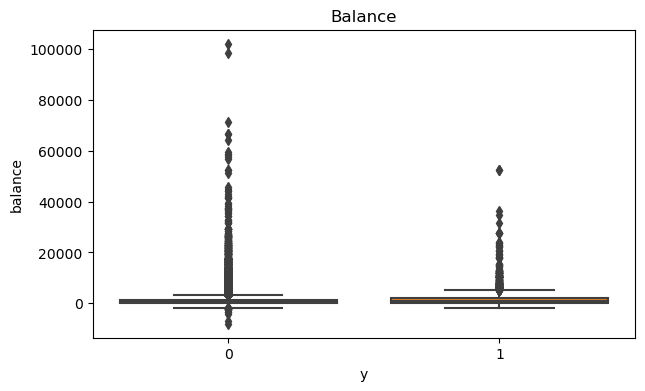

In [40]:
plt.figure(figsize= (7,4))
plt.title("Balance")
sns.boxplot(x=df["y"], y=df["balance"])
plt.show()

Utilizamos la funcion outliers

In [41]:
df_outliers_balance=outliers(df, "balance")

Outliers_balance: 4361
Los outliers de esta columna represetan: 10.5 %


#### D) Campaign

Es el número de contactos realizados durante esta campaña y para este cliente (numérico, incluye  último contacto.

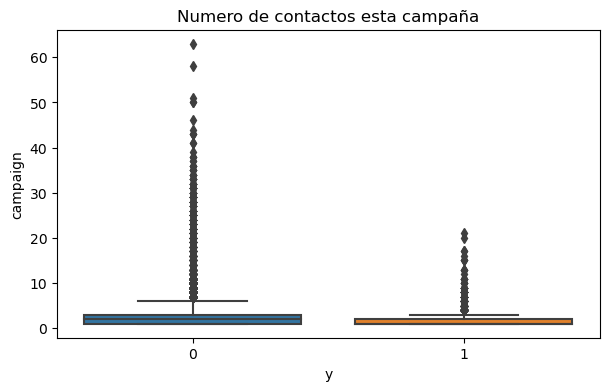

In [42]:
plt.figure(figsize= (7,4))
plt.title("Numero de contactos esta campaña")
sns.boxplot(x=df["y"], y=df["campaign"])
plt.show()

Vamos a considerarlo una variable categorica que cuenta las veces que se contacto al cliente, dividida de la siguiente forma: veces_contacto(1,2,3,4) la ultima clasificasion se interpreta 4 o mas.

In [43]:
df["campaign"].value_counts(normalize= True)

1     0.389043
2     0.275377
3     0.120502
4     0.077679
5     0.039140
6     0.029030
7     0.016417
8     0.012204
9     0.007318
10    0.005994
11    0.004477
12    0.003442
13    0.002985
14    0.002094
15    0.001950
16    0.001854
17    0.001517
18    0.001228
19    0.001035
20    0.001011
21    0.000818
22    0.000554
23    0.000530
25    0.000506
24    0.000433
28    0.000385
29    0.000361
26    0.000313
31    0.000289
27    0.000241
32    0.000193
30    0.000193
33    0.000144
34    0.000120
35    0.000096
36    0.000096
38    0.000072
43    0.000072
41    0.000048
37    0.000048
50    0.000048
39    0.000024
46    0.000024
58    0.000024
51    0.000024
63    0.000024
44    0.000024
Name: campaign, dtype: float64

In [44]:
df["campaign"]= df["campaign"].apply(lambda x: 4 if x > 3 else x)

#### D) Pdays

Número de días que pasaron después de que el cliente fue contactado por última vez desde un  campaña anterior (numérico, -1 significa que el cliente no fue contactado previamente). 

In [45]:
df["pdays"].value_counts(normalize=True).sort_index()*100

-1      81.765881
 1       0.028886
 2       0.084250
 3       0.002407
 4       0.004814
          ...    
 838     0.002407
 842     0.002407
 850     0.002407
 854     0.002407
 871     0.002407
Name: pdays, Length: 549, dtype: float64

El % de -1no fue contactado anteriormente, y el resto de datos esta muy segregado,
entonces vamos a enfocar a esta columna fue contactado 1, no fue contactado 0.


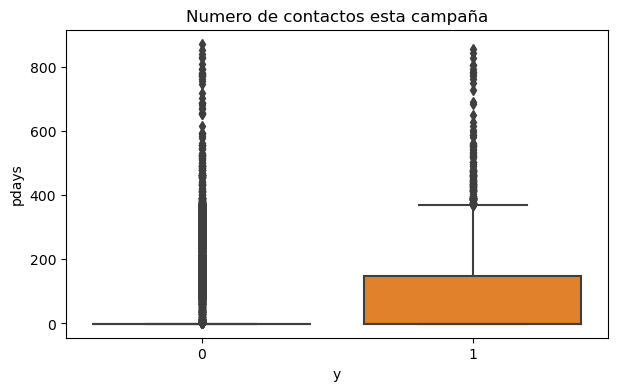

In [46]:
plt.figure(figsize= (7,4))
plt.title("Numero de contactos esta campaña")
sns.boxplot(x=df["y"], y=df["pdays"])
plt.show()

In [47]:
df["pdays"]= df["pdays"].apply(lambda x: 0 if x==-1 else 1)

In [48]:
df["pdays"].value_counts(normalize= True)*100

0    81.765881
1    18.234119
Name: pdays, dtype: float64

#### E) Days

Quitamos la columna dia porque no podemos identificar el dia 
de la semana con los datos que tenemos

In [49]:
df.drop("day", axis=1, inplace= True)

#### F) Previous

 Número de contactos realizados antes de esta campaña y para este cliente
 0-No se contacto 1-Se contacto

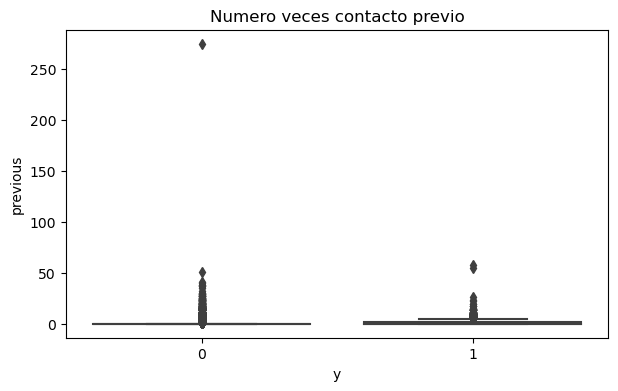

In [50]:
plt.figure(figsize= (7,4))
plt.title("Numero veces contacto previo")
sns.boxplot(x=df["y"], y=df["previous"])
plt.show()

In [51]:
df["previous"].value_counts(normalize= True)*100 

0      81.765881
1       6.130997
2       4.708374
3       2.455287
4       1.574272
5       1.023036
6       0.611415
7       0.442915
8       0.284043
9       0.202200
10      0.144429
11      0.142022
12      0.091471
13      0.089064
14      0.045736
15      0.043329
17      0.036107
16      0.028886
19      0.026479
23      0.019257
20      0.016850
22      0.014443
18      0.012036
27      0.012036
24      0.012036
25      0.009629
21      0.007221
29      0.007221
38      0.004814
37      0.004814
26      0.004814
30      0.004814
28      0.004814
51      0.002407
275     0.002407
58      0.002407
32      0.002407
40      0.002407
55      0.002407
35      0.002407
41      0.002407
Name: previous, dtype: float64

In [52]:
df["previous"]= df["previous"].apply(lambda x: 1 if x >0 else 0)

In [53]:
df["previous"].value_counts(normalize= True)*100

0    81.765881
1    18.234119
Name: previous, dtype: float64

En los resultados del procesamiento de las columnas previus y pdays, se observa que tras las consideraciones hechas el resultado de ambas columnas coincide ya que una esta contenida en la otra de manera conceptual,  con lo que eliminamos la columna pdays, que tiene menos indice de corr

In [54]:
df.drop("pdays", axis=1, inplace=True)

In [55]:
df["y"].value_counts(normalize= True)*100

0    91.685723
1     8.314277
Name: y, dtype: float64

Los outliers de la columna edad son los mayores de 70 y cuantifican 487 instancias. Lo que representa un 1% del total de datos.

/Users/lucasfernandezmartinez/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



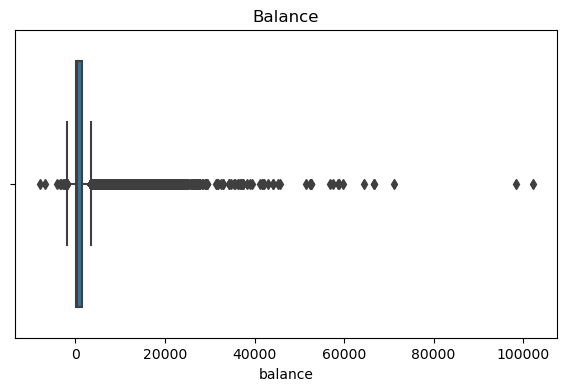

In [56]:
plt.figure(figsize= (7,4))
plt.title("Balance")
sns.boxplot(df["balance"], orient= "h")
plt.show()

In [57]:
df["balance"].describe()

count     41543.000000
mean       1332.896252
std        2995.514755
min       -8019.000000
25%          68.000000
50%         433.000000
75%        1390.500000
max      102127.000000
Name: balance, dtype: float64

### 3.4 Conclusiones

#### 3.4.1 Tasa de éxito

In [58]:
df.y.value_counts(normalize = True) * 100

0    91.685723
1     8.314277
Name: y, dtype: float64

#### 3.4.2 Perfil tipo de venta exitosa (Inssights)



El perfil medio del comprador, sin prejuicio de resultados de análisis posteriores es :

* Estudiante, jubilado o desempleado
* Ed. superior
* Single o separado
* Tiene prestano tarjeta
* Tiene prestamo casa
* Mejor venta por movil que fijo

Este dato también es muy interesante porque nos permite determinar el presupuesto para acciones de retención por departamento o perfil.

Ya que sabemos que podemos gastarnos hasta 37.000$ sólo en acciones específicas para retener a representantes de ventas y se estarían pagando sólas con la pérdida evitada

# 4. TRANSFORMACIÓN DE DATOS

En primer lugar se realiza una copia de la base de datos con la copia.

In [59]:
df_ml = df.copy()

In [60]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41543 entries, 0 to 45210
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                41543 non-null  int32 
 1   job                41543 non-null  int64 
 2   education          41543 non-null  object
 3   balance            41543 non-null  int32 
 4   duration           41543 non-null  int32 
 5   campaign           41543 non-null  int64 
 6   previous           41543 non-null  int64 
 7   y                  41543 non-null  int32 
 8   Marital_single     41543 non-null  uint8 
 9   Default_yes        41543 non-null  uint8 
 10  Housing_yes        41543 non-null  uint8 
 11  Loan_yes           41543 non-null  uint8 
 12  Contact_telephone  41543 non-null  uint8 
dtypes: int32(4), int64(3), object(1), uint8(5)
memory usage: 2.4+ MB


## 4.1 Variables categóricas a numéricas

Priero pasamos las variables categóricas a numéricas.

In [61]:
cat = df_ml.select_dtypes('O')

In [62]:
cat_cols = cat.columns
cat_cols
for i in cat_cols:
    print (cat[i].unique())

['tertiary' 'secondary' 'unknown' 'primary']


In [63]:
cc1 = pd.get_dummies(data = cat["education"])

In [64]:
cat1 = pd.concat([cat, cc1],axis = 1)

In [65]:
cat1["education"] = cat["education"].map({"primary":0, "secondary":0,"tertiary":1, "unknown": 0})

In [66]:
cat2 = cat1.drop(["primary", "secondary", "tertiary", "unknown"], axis = 1)

## 4.2 Variables numéricas

In [67]:
num = df.select_dtypes('number').reset_index(drop = True)

## 4.3 Unión de variables

In [68]:
df_ml = pd.concat([cat2,num], axis = 1)
df_ml.info()
df_ml.dropna()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44663 entries, 0 to 41524
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   education          41543 non-null  float64
 1   age                41543 non-null  float64
 2   job                41543 non-null  float64
 3   balance            41543 non-null  float64
 4   duration           41543 non-null  float64
 5   campaign           41543 non-null  float64
 6   previous           41543 non-null  float64
 7   y                  41543 non-null  float64
 8   Marital_single     41543 non-null  float64
 9   Default_yes        41543 non-null  float64
 10  Housing_yes        41543 non-null  float64
 11  Loan_yes           41543 non-null  float64
 12  Contact_telephone  41543 non-null  float64
dtypes: float64(13)
memory usage: 4.8 MB


,education,age,job,balance,duration,campaign,previous,y,Marital_single,Default_yes,Housing_yes,Loan_yes,Contact_telephone
0,1.0,58.0,4.0,2143.0,261.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,44.0,9.0,29.0,151.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,33.0,2.0,2.0,76.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,0.0,47.0,1.0,1506.0,92.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,33.0,11.0,1.0,198.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41538,0.0,34.0,0.0,557.0,224.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
41539,0.0,23.0,8.0,113.0,266.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
41540,0.0,25.0,9.0,505.0,386.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
41541,0.0,57.0,1.0,668.0,508.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [69]:
df_ml

,education,age,job,balance,duration,campaign,previous,y,Marital_single,Default_yes,Housing_yes,Loan_yes,Contact_telephone
0,1.0,58.0,4.0,2143.0,261.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,44.0,9.0,29.0,151.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,33.0,2.0,2.0,76.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,0.0,47.0,1.0,1506.0,92.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,33.0,11.0,1.0,198.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41506,NaN,48.0,0.0,178.0,228.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41515,NaN,54.0,0.0,66.0,167.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
41516,NaN,36.0,0.0,1224.0,482.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
41522,NaN,70.0,5.0,324.0,78.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Pasamos el archivo a CSV para exportarlo al siguienet Notebook.

In [70]:
df_ml.to_csv("dfbank_clean.csv")

In [71]:
dfbal0 = df_ml[df_ml["y"]==0]

# 5. MODELO DE MACHINE LEARNING (ARBOL)

En este apartado se procede desarrollar el modelo de Machine Learning.

Antes de comenzar el prceso, revisamos que no existan nulos.

In [72]:
df_ml.isnull().sum()

education            3120
age                  3120
job                  3120
balance              3120
duration             3120
campaign             3120
previous             3120
y                    3120
Marital_single       3120
Default_yes          3120
Housing_yes          3120
Loan_yes             3120
Contact_telephone    3120
dtype: int64

In [73]:
df_ml.dropna(inplace = True)

In [74]:
df_ml.isnull().sum()

education            0
age                  0
job                  0
balance              0
duration             0
campaign             0
previous             0
y                    0
Marital_single       0
Default_yes          0
Housing_yes          0
Loan_yes             0
Contact_telephone    0
dtype: int64

## 5.1 Selección de variables (Reducción de Dimensionalidad)

A continuación se procede a seleccionar las variables relevantes para el modelo. No se puede aplicar una reducción en base a la varianza ya que como hay muchas variables categóricas, por lo que se se opta por utilizar una selección mediante un Decission Tree.

In [75]:
df_ml1 = df_ml.copy()

In [76]:
df_ml1

,education,age,job,balance,duration,campaign,previous,y,Marital_single,Default_yes,Housing_yes,Loan_yes,Contact_telephone
0,1.0,58.0,4.0,2143.0,261.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,44.0,9.0,29.0,151.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.0,33.0,2.0,2.0,76.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,0.0,47.0,1.0,1506.0,92.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,33.0,11.0,1.0,198.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41538,0.0,34.0,0.0,557.0,224.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
41539,0.0,23.0,8.0,113.0,266.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
41540,0.0,25.0,9.0,505.0,386.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
41541,0.0,57.0,1.0,668.0,508.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 5.1.2 Variables de mayor importancia

In [77]:
x = df_ml1.drop(columns=("y")) 

In [78]:
y = df_ml1["y"] 

In [79]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3) 

In [80]:
ac = DecisionTreeClassifier(max_depth=5) 

In [81]:
ac.fit(train_x,train_y)

DecisionTreeClassifier(max_depth=5)

In [82]:
yhat = ac.predict(test_x)

In [83]:
print("Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)", roc_auc_score(test_y,yhat))
print("Jaccard Index:", jaccard_score(test_y, yhat, average = "macro"))
print("Accuracy:"     , accuracy_score(test_y, yhat))
print("Precisión:"    , precision_score(test_y, yhat, average = "macro"))
print("Sensibilidad:" , recall_score(test_y, yhat, average = "macro"))
print("F1-score:"     , f1_score(test_y, yhat, average = "macro"))

Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) 0.6001332910824221
Jaccard Index: 0.5511552346570397
Accuracy: 0.9214019259130737
Precisión: 0.7337943173781778
Sensibilidad: 0.6001332910824221
F1-score: 0.6333651399491094


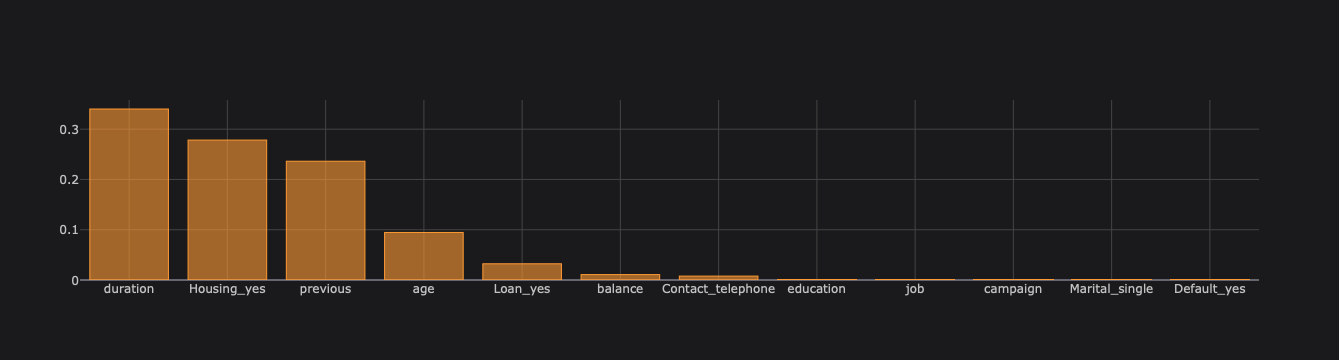

In [84]:
results2 = pd.Series(ac.feature_importances_,index = test_x.columns).sort_values(ascending= False)
results2.iplot(kind = "bar")

In [85]:
print(results2)

duration             0.340114
Housing_yes          0.278284
previous             0.236260
age                  0.094546
Loan_yes             0.032268
balance              0.010756
Contact_telephone    0.007772
education            0.000000
job                  0.000000
campaign             0.000000
Marital_single       0.000000
Default_yes          0.000000
dtype: float64
